# Visualize Matcher

This notebook visualizes the results of the Hungarian matcher. For debugging purposes

In [1]:
import os
import sys
import warnings
import itertools
import random
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
import torch.nn.functional as nnF
import torchvision.transforms.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("white", {
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})

%matplotlib inline
# import seaborn as sns
# sns.set()

from sparse_detector.configs import (
    build_dataset_config,
    build_detr_config,
    build_matcher_config,
    load_base_configs,
    load_config
)
from sparse_detector.models import build_model
from sparse_detector.models.matcher import build_matcher
from sparse_detector.models.utils import describe_model
from sparse_detector.datasets.loaders import build_dataloaders
from sparse_detector.utils.logging import MetricLogger
import sparse_detector.datasets.transforms as T
from sparse_detector.utils.box_ops import box_cxcywh_to_xyxy
from sparse_detector.visualizations import ColorPalette
from sparse_detector.datasets.coco import CLASSES

In [2]:
seed = 42
detr_config_file = Path(package_root) / "configs" / "decoder_sparsemax_baseline.yml"
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda")

base_config = load_config(Path(package_root) / "configs" / "base.yml")
detr_config = build_detr_config(detr_config_file, params=None, device=device)
matcher_config = build_matcher_config(detr_config_file)

# Surgery for path
dataset_config = build_dataset_config(base_config["dataset"], params=None)
dataset_config['coco_path'] = Path(package_root) / "data" / "COCO"

detr_config["average_cross_attn_weights"] = True

# Build model
model, criterion, _ = build_model(**detr_config)
resume_from_checkpoint = Path(package_root) / "checkpoints" / "v2_decoder_sparsemax" / "checkpoint.pth"
print(f"Load model from checkpoint: {resume_from_checkpoint}")
checkpoint = torch.load(resume_from_checkpoint, map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.eval()
model.to(device)
describe_model(model)
criterion.eval()

print("Building matcher")
matcher = build_matcher(
    set_cost_class=matcher_config["set_cost_class"],
    set_cost_bbox=matcher_config["set_cost_bbox"],
    set_cost_giou=matcher_config["set_cost_giou"],
)

print("Building dataset")
data_loader, _ = build_dataloaders(
    "val",
    dataset_config["coco_path"],
    1, # dataset_config["batch_size"],
    False,
    dataset_config["num_workers"],
)

metric_logger = MetricLogger(delimiter=" ")

reverse_normalize = T.Normalize(
    [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    [1/0.229, 1/0.224, 1/0.225]
)

Cross-attention activation: sparsemax; average attention weights: True
Transformer.reset_parameters()
Load model from checkpoint: /proj/azizpour-group/users/cuongdao/projects/sparse-detector/checkpoints/v2_decoder_sparsemax/checkpoint.pth
+-------------+-------------+-----------------+
| Module      |   Trainable |   Non-trainable |
|-------------+-------------+-----------------|
| class_embed |       23644 |               0 |
| query_embed |       25600 |               0 |
| backbone    |    23232512 |          222400 |
| input_proj  |      524544 |               0 |
| bbox_embed  |      132612 |               0 |
| transformer |    17363968 |               0 |
|             |             |                 |
| Total       |    41302880 |          222400 |
+-------------+-------------+-----------------+
Building matcher
Building dataset
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


**Load a sample batch of data**

In [3]:
batch_images, batch_targets = next(itertools.islice(
    metric_logger.log_every(data_loader, log_freq=10, header=None, prefix="val"), 5, None
))
# samples [B, 3, H, W]: NestedTensor
# targets: tuple of length B. Each target is a dictionary of keys:
# - boxes: [X, 4] Tensor of all groundtruth boxes
# - labels: [X] Tensor
# - image_id: Tensor - id of the image, convenient for retreiving the actual image
# - area: Tensor
# - iscrowd: Tensor
# - orig_size: Tensor[H, W] original size of the image
# - size: resized version

 [   0/5000] global step: None eta: 2:40:47  time: 1.9295 data: 1.9294 max mem: 159


**Visualize a sample data point: image + bounding boxes**

In [4]:
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def draw_box_on_ax(box, ax, text=None, color=None):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin

    color = color or ColorPalette.GREEN
    rect = patches.Rectangle((xmin, ymin), width, height,
                    fill=False, color=color, linewidth=2, zorder=1000, axes=ax)
    ax.add_artist(rect)

    if text:
        ax.text(xmin, ymin, text, fontsize=14, bbox=dict(facecolor=ColorPalette.GREEN, alpha=0.5))

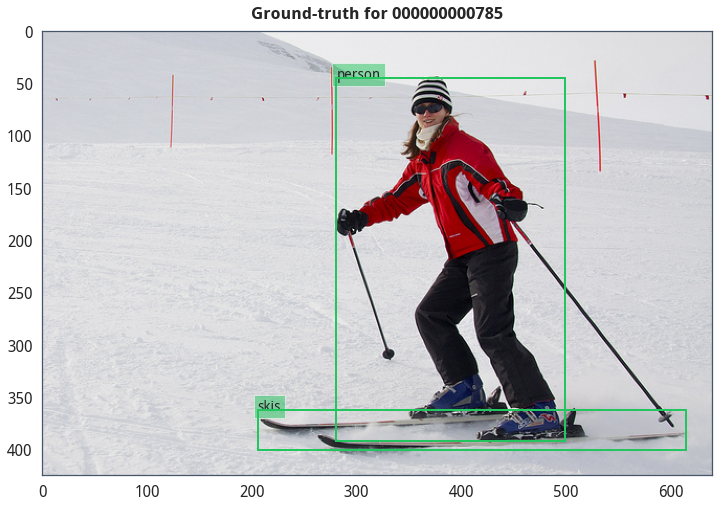

In [8]:
idx = 0
sample_img, sample_target = batch_images.tensors[idx], batch_targets[idx]

img_id = sample_target['image_id'].item()
img_name = str(img_id).rjust(12, '0')
img = Image.open(Path(package_root) / "data" / "COCO" / "val2017" / f"{img_name}.jpg")

boxes = sample_target['boxes']
# boxes = rescale_bboxes(boxes, img.size)
orig_h, orig_w = sample_target['orig_size']
boxes = rescale_bboxes(boxes, (orig_w, orig_h))
labels = sample_target['labels']

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(np.asarray(img))
for (box, label) in zip(boxes, labels):
    text = f"{CLASSES[label.item()]}"
    draw_box_on_ax(box, ax, text=text)

    title = f"Ground-truth for {img_name}"
    ax.set_title(title, pad=12, fontweight='bold')

**Get the predictions from the model given the input batches**

In [9]:
conv_features, dec_attn_weights = [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

outputs = model(batch_images.to(device))

for hook in hooks:
    hook.remove()

pred_logits = outputs['pred_logits'].detach().cpu()
pred_boxes = outputs['pred_boxes'].detach().cpu()
print(f"pred_logits={pred_logits.shape};\t pred_boxes={pred_boxes.shape}")

pred_logits=torch.Size([1, 100, 92]);	 pred_boxes=torch.Size([1, 100, 4])


**Widly visualize all the predicted boxes for the image above**

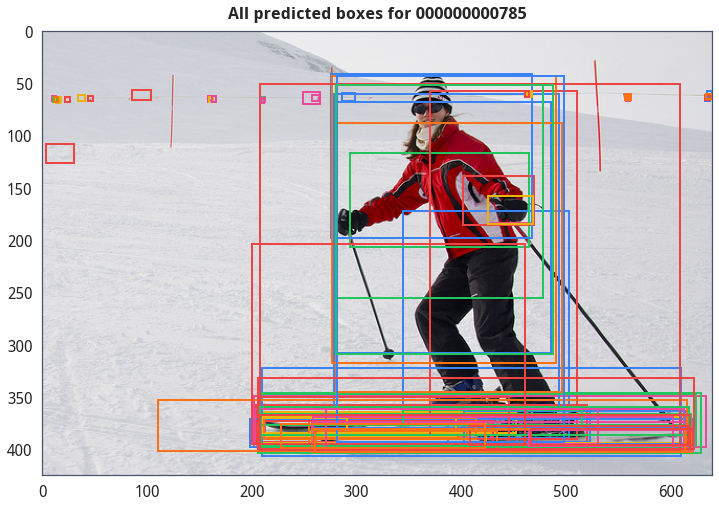

In [10]:
predictions = pred_boxes[idx]

predictions = rescale_bboxes(predictions, (orig_w, orig_h))

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(np.asarray(img))

colors = [ColorPalette.RED, ColorPalette.BLUE, ColorPalette.GREEN, ColorPalette.ORANGE, ColorPalette.YELLOW, ColorPalette.PINK]

for box in predictions:
    draw_box_on_ax(box, ax, color=random.choice(colors))
    ax.set_title(f"All predicted boxes for {img_name}", pad=12, fontweight='bold')

**Match the predictions with groundtruth**

In [11]:
targets = [{k: v.to(device) for k, v in t.items()} for t in batch_targets]
match_indices = matcher(outputs, targets)
match_indices

[(tensor([82, 93]), tensor([0, 1]))]

Only for the image above

In [12]:
img_match_indices = match_indices[idx]
img_preds, img_gts = img_match_indices
img_match_indices

(tensor([82, 93]), tensor([0, 1]))

**Visualize matched predictions and ground-truth boxes**

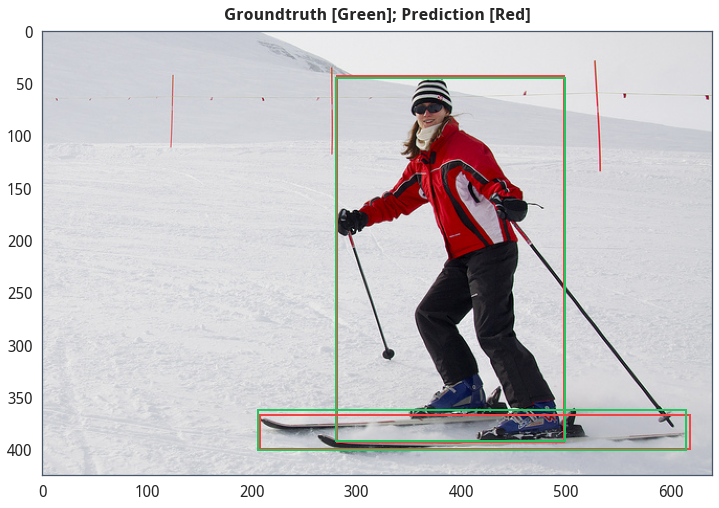

In [13]:
gt_bboxes = sample_target['boxes']
gt_bboxes = rescale_bboxes(gt_bboxes, (orig_w, orig_h))
pred_bboxes = rescale_bboxes(pred_boxes[idx], (orig_w, orig_h))

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(np.asarray(img))

for (pred_id, gt_id) in zip(img_preds, img_gts):
    pred_id = pred_id.item()  # tensor -> int
    draw_box_on_ax(pred_bboxes[pred_id], ax, color=ColorPalette.RED)

    gt_id = gt_id.item()  # tensor -> int
    draw_box_on_ax(gt_bboxes[gt_id], ax, color=ColorPalette.GREEN)

ax.set_title("Groundtruth [Green]; Prediction [Red]", pad=12, fontweight='bold')
fig.savefig(f'../temp/{img_name}_matched.png', bbox_inches='tight')

## Attentions

In [14]:
conv_features = conv_features[0]
h, w = conv_features['3'].tensors.shape[-2:]
print(f"h={h}, w={w}")

h=25, w=38


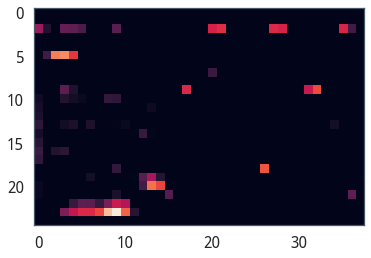

In [15]:
conv_features['3'].tensors.shape
plt.imshow(conv_features['3'].tensors[0, 0].detach().cpu())

torch.Size([25, 38])


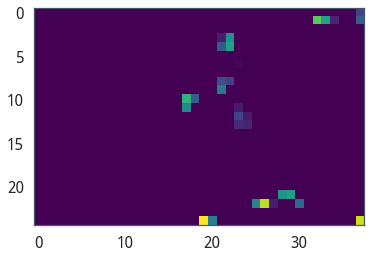

In [16]:
attentions = dec_attn_weights[0][idx]
match_attns = attentions[82]

attn = match_attns.reshape(h, w).detach().cpu()
print(attn.shape)
plt.imshow(attn, cmap='viridis')

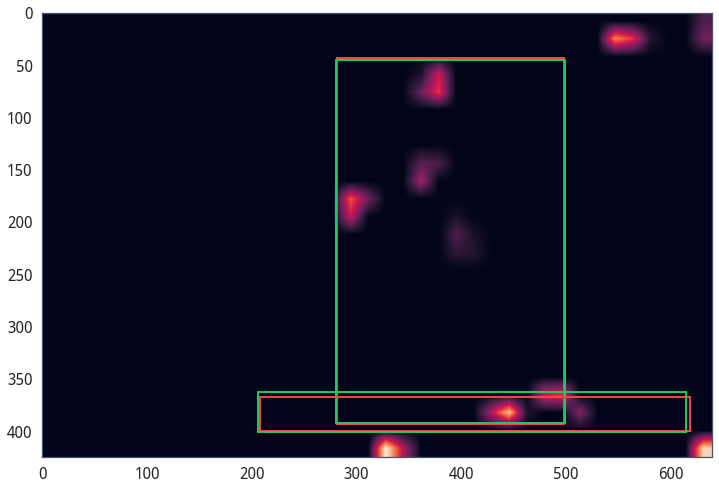

In [17]:
int_attn = nnF.interpolate(attn.unsqueeze(0).unsqueeze(0), (orig_h, orig_w), mode='bilinear').squeeze(0).squeeze(0)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(np.asarray(int_attn))

for (pred_id, gt_id) in zip(img_preds, img_gts):
    pred_id = pred_id.item()  # tensor -> int
    draw_box_on_ax(pred_bboxes[pred_id], ax, color=ColorPalette.RED)

    gt_id = gt_id.item()  # tensor -> int
    draw_box_on_ax(gt_bboxes[gt_id], ax, color=ColorPalette.GREEN)

In [18]:
gt_box_coord = gt_bboxes[0].type(torch.int16)
gt_box_coord

tensor([280,  44, 499, 391], dtype=torch.int16)

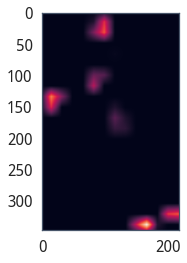

In [19]:
xmin, ymin, xmax, ymax = gt_box_coord
attn_inside = int_attn[ymin:ymax, xmin:xmax]
plt.imshow(attn_inside.numpy())

In [20]:
attn_inside.sum() / int_attn.sum()

tensor(0.5602)